# Azure Databricks Assessment 1

In [1]:
# Install dependencies (only needed in Google Colab)
# In Azure Databricks, skip this cell
!pip install pyspark==3.5.1 delta-spark==3.1.0
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

In [2]:
# using DELTA in colab
!pip install delta-spark==3.2.0 -q
import pyspark
from delta import *
from pyspark.sql.functions import *

# Create a SparkSession with Delta Lake extensions
# The '.config(...)' lines are crucial for enabling Delta Lake's features
builder = pyspark.sql.SparkSession.builder.appName("DeltaDemo") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

# Get or create the SparkSession
spark = configure_spark_with_delta_pip(builder).getOrCreate()

print("Spark and Delta Lake are ready!")

Spark and Delta Lake are ready!


# Exercise Set



In [3]:
# Create sample DataFrame
data = [
        (1, "John", "Electronics", 2, 300),
        (2, "Sara", "Clothing", 1, 50),
        (3, "Mike", "Electronics", 4, 600),
        (4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
df = spark.createDataFrame(data, columns)

In [4]:
# Save as Delta table
df.write.format("delta").mode("overwrite").save("/tmp/orders_delta")

# Display
display(spark.read.format("delta").load("/tmp/orders_delta"))

# Show
df.show()

DataFrame[order_id: bigint, customer_name: string, category: string, quantity: bigint, amount: bigint]

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



# 1. Managed vs Unmanaged Tables
Task:

    Create a managed table orders_managed from /tmp/orders_delta
    Create an unmanaged table orders_unmanaged pointing to the same location

In [5]:
# Create a managed table orders_managed from /tmp/orders_delta
# Managed Table
spark.sql("CREATE TABLE IF NOT EXISTS orders_managed USING DELTA LOCATION '/tmp/orders_delta'")

# Create an unmanaged table orders_unmanaged pointing to the same location
# Unmanaged Table
spark.sql("CREATE TABLE IF NOT EXISTS orders_unmanaged USING DELTA LOCATION '/tmp/orders_delta'")

# Verify
spark.sql("SHOW TABLES").show()

+---------+----------------+-----------+
|namespace|       tableName|isTemporary|
+---------+----------------+-----------+
|  default|  orders_managed|      false|
|  default|orders_unmanaged|      false|
+---------+----------------+-----------+



In [6]:
# Things to Understand

# Step 1: Create both tables (managed and unmanaged) pointing to the same Delta files.

# Step 2: Do CRUD operations, time travel, streaming, etc. on orders_managed (so your changes are visible in both because they share the same underlying files).

# Step 3: At the end, drop the managed table and observe that the data files get deleted; drop the unmanaged table and notice the files remain.


# 2. CRUD Operations
Task:

    Read from the table
    Update all "Clothing" category orders to have amount = amount + 20
    Delete all orders with quantity < 2
    Merge in a new dataset (new orders & updated orders)

In [7]:
from delta.tables import DeltaTable

# Load Delta table
orders_delta = DeltaTable.forPath(spark, "/tmp/orders_delta")

In [8]:
# Read from the table
spark.sql("SELECT * FROM orders_managed").show()

# Read from the table
spark.sql("SELECT * FROM orders_unmanaged").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



In [9]:
# Update all "Clothing" category orders to have amount = amount + 20
spark.sql("UPDATE orders_managed SET amount = amount + 20 WHERE category = 'Clothing'")

# Verify
spark.sql("SELECT * FROM orders_managed").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
+--------+-------------+-----------+--------+------+



In [10]:
# Delete all orders with quantity < 2
spark.sql("DELETE FROM orders_managed WHERE quantity < 2")

# Verify
spark.sql("SELECT * FROM orders_managed").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
+--------+-------------+-----------+--------+------+



In [11]:
# Merge in a new dataset (new orders & updated orders)
new_data = [
    (3, "Mike", "Electronics", 5, 750),  # Updated
    (5, "Liam", "Electronics", 1, 200),  # New
]

columns = ["order_id", "customer_name", "category", "quantity", "amount"]
new_df = spark.createDataFrame(new_data, columns)

orders_delta.alias("old").merge(
    new_df.alias("new"),
    "old.order_id = new.order_id"
).whenMatchedUpdateAll(
).whenNotMatchedInsertAll().execute()

# Verify
spark.sql("SELECT * FROM orders_managed").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|Electronics|       1|   200|
|       1|         John|Electronics|       2|   300|
+--------+-------------+-----------+--------+------+



 # 3. History & Time Travel
Task:

    Use DESCRIBE HISTORY to check previous versions
    Read data from version 0 and compare with the latest version

In [12]:
# Use DESCRIBE HISTORY to check previous versions
(spark.sql("DESCRIBE HISTORY orders_managed")).show()

+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      3|2025-08-14 06:12:...|  NULL|    NULL|    MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|          2|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|      2|2025-08-14 06:12:...|  NULL|    NULL|   DELETE|{predicate -> ["(...|NULL|    NULL|     NULL|          1|  Serializable|        false|{numRemovedFiles ...|        NULL|Apache-Spark/3.5....|
|      1|2

In [13]:
# Read data from version 0 and compare with the latest version

# 1. Read version 0
old_df = spark.read.format("delta").option("versionAsOf", 0).load("/tmp/orders_delta")
print("Version 0 Data:")
old_df.show()

Version 0 Data:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



In [14]:
# 2. Read latest version
latest_df = spark.read.format("delta").load("/tmp/orders_delta")
print("Latest Version Data:")
latest_df.show()

Latest Version Data:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|Electronics|       1|   200|
|       1|         John|Electronics|       2|   300|
+--------+-------------+-----------+--------+------+



In [15]:
# 3. Find rows that changed between version 0 and latest
changes = latest_df.subtract(old_df)
print("Changes from Version 0 to Latest:")
changes.show()

Changes from Version 0 to Latest:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       4|         Nina|   Clothing|       3|   170|
|       3|         Mike|Electronics|       5|   750|
|       5|         Liam|Electronics|       1|   200|
+--------+-------------+-----------+--------+------+



# 4. Incremental Load Pattern
Task:

    Create a new mini-batch with only new orders (IDs 5 & 6)
    Append to the Delta table
    Show final result

In [16]:
# Create a new mini-batch with only new orders (IDs 6 & 7)
new_batch = [
    (6, "Priya", "Electronics", 5, 116),
    (7, "Olivia", "Clothing", 2, 100),
]

In [17]:
# Create DataFrame
new_df = spark.createDataFrame(new_batch, columns)
# Append to the Delta table
new_df.write.format("delta").mode("append").save("/tmp/orders_delta")

In [18]:
# Show final result from managed table
spark.sql("SELECT * FROM orders_managed").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|Electronics|       1|   200|
|       6|        Priya|Electronics|       5|   116|
|       1|         John|Electronics|       2|   300|
|       7|       Olivia|   Clothing|       2|   100|
+--------+-------------+-----------+--------+------+



# 5. Simple Streaming Read
Task:

    Read the /tmp/orders_delta in streaming mode
    Output to console every 5 seconds

In [19]:
# Read the /tmp/orders_delta in streaming mode
streaming_df = spark.readStream.format("delta").load("/tmp/orders_delta")

In [20]:
# Output to console every 5 seconds
query = (
    streaming_df.writeStream
    .format("console")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .start()
)

# Wait 20 seconds to view some batches
import time
time.sleep(20)

# Stop the stream
query.stop()

# 6. Visualization
Task:

    Read Delta table into Pandas
    Create a bar chart of category vs total amount

In [22]:
# Read Delta table into Pandas and show

import pandas as pd

df_pandas = spark.read.format("delta").load("/tmp/orders_delta").toPandas()
df_pandas

,order_id,customer_name,category,quantity,amount
0,3,Mike,Electronics,5,750
1,4,Nina,Clothing,3,170
2,5,Liam,Electronics,1,200
3,6,Priya,Electronics,5,116
4,1,John,Electronics,2,300
5,7,Olivia,Clothing,2,100


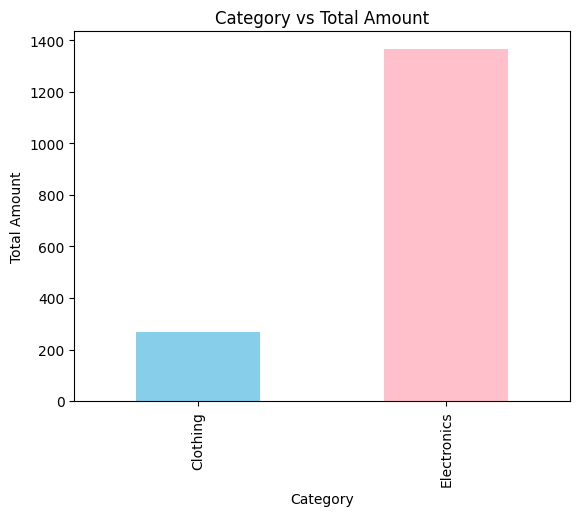

In [26]:
# Create a bar chart of category vs total amount
import matplotlib.pyplot as plt

category_amount = df_pandas.groupby("category")["amount"].sum()
category_amount.plot(kind="bar", color=["skyblue", "pink"])
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()